# Portfolio Optimization with Quadratic Programming

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

## Data

In [2]:
import os
os.chdir(os.path.expanduser('./data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [104]:
data_period = df_countries.loc[days_to_recalculate.iloc[-1]:]
data_period

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2023-12-05,454.7562,62.02,32.36,35.13,37.60,45.64,28.69,22.34,42.24,36.59,...,22.4592,40.90,48.20,47.27,61.54,33.74,8.06,39.70,63.42,21.14
2023-12-06,452.9237,62.67,32.32,34.94,37.64,45.75,28.76,22.54,42.25,36.95,...,22.2724,40.88,48.11,47.34,61.14,33.64,8.06,39.71,63.79,21.09
2023-12-07,456.3797,63.15,32.50,34.92,37.86,45.63,28.89,22.74,42.70,37.41,...,22.4297,40.92,48.64,47.46,61.80,33.60,8.06,39.86,63.54,21.14
2023-12-08,458.3417,62.78,32.58,35.06,38.31,45.95,29.00,22.82,42.90,37.46,...,22.4592,40.45,48.55,47.31,62.16,33.85,8.06,39.22,63.93,21.00
2023-12-11,460.1245,63.14,32.56,35.13,38.37,46.11,29.04,22.81,43.19,37.72,...,22.4690,40.78,48.85,47.56,62.71,33.76,8.06,39.34,63.94,21.09
2023-12-12,462.2260,63.05,32.60,34.92,38.47,46.44,29.10,22.87,43.50,37.84,...,22.3216,41.00,48.79,47.38,63.05,33.42,8.06,39.03,64.51,21.11
2023-12-13,468.6001,64.01,32.98,35.79,38.98,47.00,29.49,23.62,44.16,38.34,...,22.7639,40.92,49.46,47.96,63.81,34.64,8.06,40.05,65.38,21.27
2023-12-14,470.1040,63.72,33.52,36.28,39.32,47.18,29.58,23.99,44.92,39.23,...,23.4912,41.33,50.16,48.35,64.65,35.06,8.06,42.05,67.82,21.42
2023-12-15,469.3300,63.17,32.87,35.95,38.96,46.81,29.27,23.83,44.65,39.39,...,23.4814,41.20,49.50,48.30,63.94,34.59,8.06,41.83,67.71,21.35
2023-12-18,471.9700,62.18,32.34,35.62,38.77,46.97,29.24,23.52,44.14,38.55,...,23.8352,39.88,43.93,48.46,62.56,33.99,8.06,40.09,67.60,20.98


## Returns and variance

In [105]:
returns = np.log(data_period).diff().dropna()
cov_returns = returns.cov()
mean_returns = returns.mean()

In [106]:
mean_returns

United States     0.002600
Japan             0.001977
United Kingdom    0.001241
Canada            0.002540
France            0.002421
Switzerland       0.003296
Germany           0.002015
Australia         0.005044
Netherlands       0.003238
Sweden            0.004457
Hong Kong         0.003632
Spain            -0.000173
Italy             0.001653
Singapore         0.002441
Denmark           0.003440
Finland           0.002810
Belgium           0.001614
Norway            0.004803
China            -0.000231
Taiwan           -0.002710
India             0.001886
Korea             0.003695
Brazil            0.002089
Russia            0.000000
South Africa      0.003018
Mexico            0.003972
Malaysia          0.000305
dtype: float64

In [107]:
cov_returns

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
United States,0.000037,0.000019,0.000029,0.000044,0.000036,0.000030,0.000036,0.000053,0.000044,0.000026,...,0.000047,0.000033,0.000020,0.000047,0.000027,0.000059,0.0,0.000033,0.000039,0.000013
Japan,0.000019,0.000072,0.000047,0.000046,0.000033,0.000026,0.000036,0.000071,0.000047,0.000050,...,0.000005,0.000080,0.000178,0.000039,0.000057,0.000072,0.0,0.000085,0.000020,0.000037
United Kingdom,0.000029,0.000047,0.000089,0.000081,0.000062,0.000041,0.000054,0.000097,0.000078,0.000075,...,0.000060,0.000073,0.000199,0.000042,0.000075,0.000108,0.0,0.000158,0.000074,0.000044
Canada,0.000044,0.000046,0.000081,0.000105,0.000067,0.000049,0.000061,0.000112,0.000079,0.000071,...,0.000085,0.000064,0.000164,0.000064,0.000064,0.000141,0.0,0.000150,0.000080,0.000043
France,0.000036,0.000033,0.000062,0.000067,0.000064,0.000046,0.000054,0.000082,0.000072,0.000052,...,0.000061,0.000053,0.000111,0.000046,0.000045,0.000091,0.0,0.000107,0.000068,0.000023
Switzerland,0.000030,0.000026,0.000041,0.000049,0.000046,0.000049,0.000045,0.000055,0.000049,0.000023,...,0.000049,0.000044,0.000044,0.000043,0.000022,0.000065,0.0,0.000069,0.000051,0.000015
Germany,0.000036,0.000036,0.000054,0.000061,0.000054,0.000045,0.000054,0.000077,0.000061,0.000042,...,0.000054,0.000050,0.000078,0.000049,0.000037,0.000083,0.0,0.000090,0.000052,0.000022
Australia,0.000053,0.000071,0.000097,0.000112,0.000082,0.000055,0.000077,0.000153,0.000105,0.000102,...,0.000078,0.000099,0.000218,0.000077,0.000085,0.000158,0.0,0.000185,0.000097,0.000054
Netherlands,0.000044,0.000047,0.000078,0.000079,0.000072,0.000049,0.000061,0.000105,0.000102,0.000079,...,0.000072,0.000115,0.000187,0.000063,0.000075,0.000105,0.0,0.000166,0.000093,0.000041
Sweden,0.000026,0.000050,0.000075,0.000071,0.000052,0.000023,0.000042,0.000102,0.000079,0.000110,...,0.000055,0.000081,0.000248,0.000052,0.000070,0.000099,0.0,0.000174,0.000082,0.000053


### Random portfolios

In [108]:
n = mean_returns.shape[0]
list_ret_p = []
list_std_p = []
list_w = []
for _ in range(10000):
    w = np.random.rand(n)           # random weights   
    w = w / np.sum(w)               # scaled to 1
    ret_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_ret_p.append(ret_p)
    list_std_p.append(std_p)
    list_w.append(w)

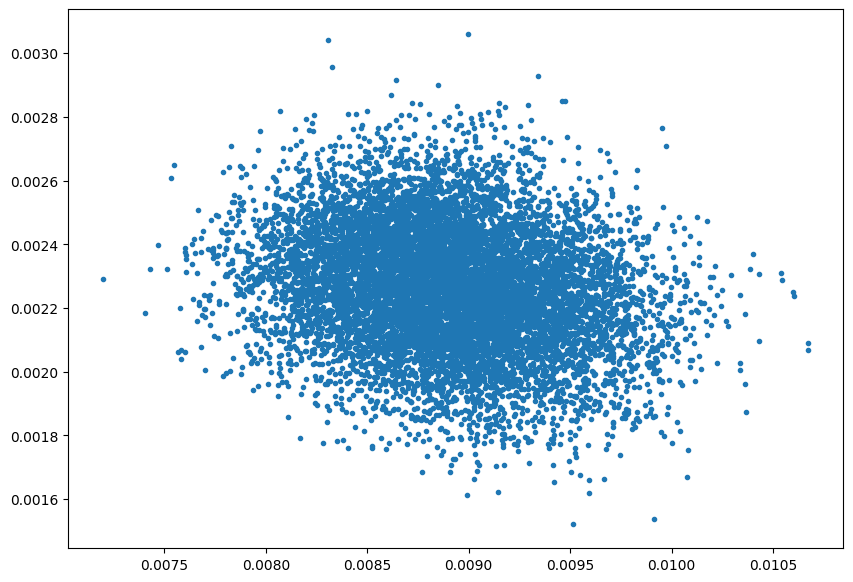

In [109]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_ret_p, '.')

In [110]:
list_w[0]

array([0.0084057 , 0.04925772, 0.03243109, 0.0108414 , 0.05500721,
       0.03119659, 0.04258206, 0.04771959, 0.06360465, 0.052815  ,
       0.04769131, 0.02974714, 0.00119892, 0.02455146, 0.02243765,
       0.01088264, 0.04900633, 0.01565915, 0.06158919, 0.0594332 ,
       0.04633517, 0.05378983, 0.0536559 , 0.03277935, 0.01577064,
       0.02433484, 0.05727629])

### Efficient Frontier Calculations

In [111]:
def efficient_frontier(returns, n_samples=20, gamma_low=-1, gamma_high=10):
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values
    n = sigma.shape[0]
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, sigma)

    prob = cp.Problem(cp.Maximize(ret - gamma*risk),
                      [cp.sum(w) == 1,
                       w[0] >= 0.30, w[0] <= 0.75,              # US
                       w[1:3] >= 0.03, w[1:3] <= 0.20,          # Japan and UK
                       w[3:8] >= 0.01, w[3:8] <= 0.08,          # Canada, France, Switzerland, Germany, Australia
                       w[8:13] >= 0.005, w[8:13] <= 0.03,       # Netherlands, Sweden, Spain, Hong Kong, Italy
                       w[13:18] >= 0.001, w[13:18] <= 0.03,     # Singapore, Denmark, Finland, Belgium, Norway
                       w[18] >= 0.01, w[18] <= 0.08,            # China
                       w[19:24] >= 0.005, w[19:24] <= 0.03,     # Taiwan, India, Korea, Brazil, Russia
                       w[24:27] >= 0.001, w[24:27] <= 0.03])    # South Africa, Mexico, Malaysia
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(gamma_low, gamma_high, num=n_samples)

    portfolio_weights = []
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)
    return ret_data, risk_data, gamma_vals, portfolio_weights

In [112]:
ret_data, risk_data, gamma_vals, portfolio_weights = efficient_frontier(returns)

### Optimal portfolio with Max Sharpe value

In [113]:
sharpes = ret_data/risk_data 
idx = np.argmax(sharpes)
optimal_ret, optimal_risk = ret_data[idx], risk_data[idx]
optimal_portfolio = pd.Series(portfolio_weights[idx],
                              index=returns.columns).round(3)

In [114]:
sharpes

array([0.4205248 , 0.4205248 , 0.4205248 , 0.43832635, 0.44368374,
       0.43891751, 0.4106518 , 0.40957128, 0.40926907, 0.40918818,
       0.40916677, 0.40916112, 0.40915963, 0.40915924, 0.40915914,
       0.40915911, 0.4091591 , 0.4091591 , 0.4091591 , 0.4091591 ])

Dibujamos la frontera eficiente y donde ocurre la cartera optima

In [115]:
optimal_portfolio

United States     0.520
Japan             0.030
United Kingdom    0.030
Canada            0.010
France            0.010
Switzerland       0.080
Germany           0.010
Australia         0.080
Netherlands       0.005
Sweden            0.030
Hong Kong         0.030
Spain             0.005
Italy             0.005
Singapore         0.001
Denmark           0.030
Finland           0.001
Belgium           0.001
Norway            0.030
China             0.010
Taiwan            0.005
India             0.005
Korea             0.030
Brazil            0.005
Russia            0.005
South Africa      0.001
Mexico            0.030
Malaysia          0.001
dtype: float64

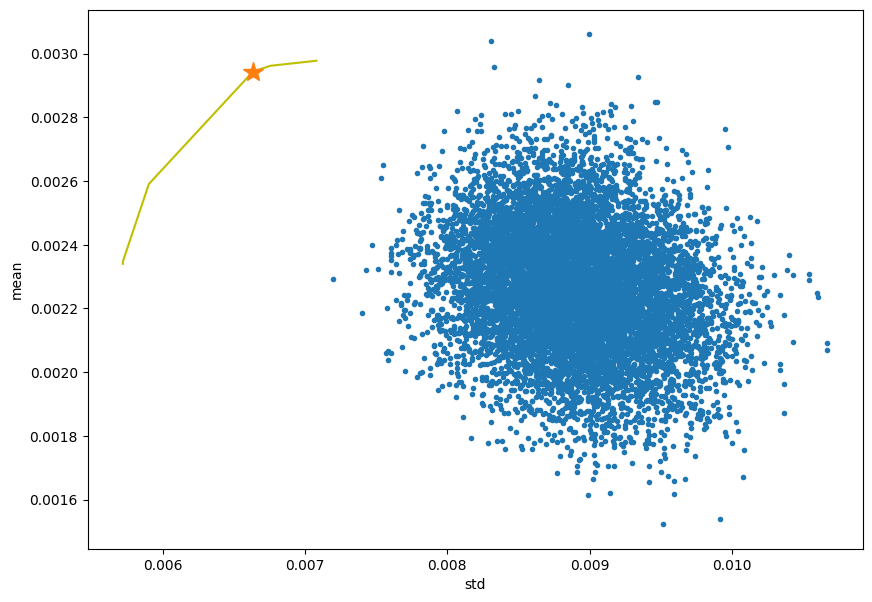

In [116]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_ret_p, '.')
ax.plot(risk_data, ret_data, 'y')
ax.plot(optimal_risk, optimal_ret, '*', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')
